In [48]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import seaborn as sns
import matplotlib.pyplot as plt

csv_firm_data = Path.cwd().parent / "Data/Firm_variables/firmcharacteristics.csv"
parquet_file = (Path.cwd().parent / "Data/Firm_variables/firmcharacteristics")

data_path = Path.cwd().parent / "Data"

firm_tickers = ["MSFT", "AMZN", "NVDA", "META", "TSLA", "WMT", "COST", "BKNG", "EXPE", "COHR"]
firm_permno = [10107, 84788, 86580, 13407, 93436, 55976, 87055, 86783, 90808, 24476]

period = [datetime.datetime(2018, 12, 31), datetime.datetime(2021, 12, 31)]
number_of_sso = len(firm_tickers)

In [4]:
pl.read_csv(csv_firm_data, separator = ",",try_parse_dates = True).estimated_size("mb")

2943.7515325546265

In [5]:
df = pl.scan_csv(csv_firm_data, separator=",")
df.schema
df.fetch(5)

permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,mom36m,pricedelay,turn,absacc,acc,age,agr,bm,bm_ia,cashdebt,cashpr,cfp,cfp_ia,chatoia,chcsho,chempia,chinv,chpmia,convind,currat,depr,divi,divo,dy,egr,…,quick,rd,rd_mve,rd_sale,realestate,roic,salecash,saleinv,salerec,secured,securedind,sgr,sin,sp,tang,tb,aeavol,cash,chtx,cinvest,ear,nincr,roaq,roavol,roeq,rsup,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
10006,19570131,82249.0,1.122846,1.260784,0.04718,9.569953,0.025742,0.046433,0.044843,-0.059517,-0.120199,1.497008,-0.121436,0.169027,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.013234,9.4116e-8,0.015453,0.008058,0.355638,0.46042,1.1210e-7,37.0
10014,19570131,3903.375,0.426734,0.182102,-0.275641,6.237836,0.072103,0.046433,-0.086957,-0.115385,-0.041667,0.5,1.229441,0.173504,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.033305,0.000007,0.047619,0.033495,1.152126,1.16961,9.2291e-8,null
10022,19570131,9273.25,1.066449,1.137313,-0.02549,7.008844,0.027648,0.046433,-0.060377,-0.03955,-0.108751,0.293601,-0.154406,0.141347,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.016023,0.000002,0.020833,0.015589,0.815777,0.679803,1.1818e-7,null
10030,19570131,54465.875,0.926038,0.857547,0.018171,9.825337,0.0217,0.046433,0.044633,0.05047,0.13365,0.311958,-0.142421,0.296051,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.015295,1.4643e-7,0.039326,0.015849,0.739302,1.333656,6.1267e-8,null
10057,19570131,40250.0,1.247748,1.556875,0.025785,7.901007,0.025506,0.046433,0.086667,0.055247,0.182844,1.558356,0.021703,0.078,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.005954,0.000001,0.056856,0.019945,0.75551,0.410391,3.31579,null


In [6]:
# df.select(pl.col("DATE")).cast(5)
# df_filter_10006 = df.filter(pl.col("permno") == 10006)
# df_test = df_filter_10006.cast({"DATE" : pl.Datetime})

In [7]:
for col_name in df.columns:
    if col_name != "DATE":
        df = df.cast({col_name: pl.Float64})

datetime_cols = ["DATE"]
int_cols = ["permno"]

df = df.cast({"permno":pl.Int64})

df_new = df.with_columns(pl.col('DATE').cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").alias('DATE'))

# df_new = df.cast({"DATE":pl.Date})

# df_new = df.select(pl.col("DATE").cast(pl.Date)).dt.year()


In [8]:
df_new.fetch(10)

permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,mom36m,pricedelay,turn,absacc,acc,age,agr,bm,bm_ia,cashdebt,cashpr,cfp,cfp_ia,chatoia,chcsho,chempia,chinv,chpmia,convind,currat,depr,divi,divo,dy,egr,…,quick,rd,rd_mve,rd_sale,realestate,roic,salecash,saleinv,salerec,secured,securedind,sgr,sin,sp,tang,tb,aeavol,cash,chtx,cinvest,ear,nincr,roaq,roavol,roeq,rsup,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
i64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,1957-01-31,82249.0,1.122846,1.260784,0.04718,9.569953,0.025742,0.046433,0.044843,-0.059517,-0.120199,1.497008,-0.121436,0.169027,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.013234,9.4116e-8,0.015453,0.008058,0.355638,0.46042,1.1210e-7,37.0
10014,1957-01-31,3903.375,0.426734,0.182102,-0.275641,6.237836,0.072103,0.046433,-0.086957,-0.115385,-0.041667,0.5,1.229441,0.173504,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.033305,0.000007,0.047619,0.033495,1.152126,1.16961,9.2291e-8,null
10022,1957-01-31,9273.25,1.066449,1.137313,-0.02549,7.008844,0.027648,0.046433,-0.060377,-0.03955,-0.108751,0.293601,-0.154406,0.141347,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.016023,0.000002,0.020833,0.015589,0.815777,0.679803,1.1818e-7,null
10030,1957-01-31,54465.875,0.926038,0.857547,0.018171,9.825337,0.0217,0.046433,0.044633,0.05047,0.13365,0.311958,-0.142421,0.296051,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.015295,1.4643e-7,0.039326,0.015849,0.739302,1.333656,6.1267e-8,null
10057,1957-01-31,40250.0,1.247748,1.556875,0.025785,7.901007,0.025506,0.046433,0.086667,0.055247,0.182844,1.558356,0.021703,0.078,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.005954,0.000001,0.056856,0.019945,0.75551,0.410391,3.31579,null
10065,1957-01-31,76945.25,1.264106,1.597964,0.193374,8.906529,0.023942,0.046433,0.077778,0.060268,0.006574,1.143012,-0.056811,0.116294,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.008934,1.3939e-7,0.022222,0.008179,0.561265,0.461107,1.6874e-7,null
10102,1957-01-31,186193.5,1.445027,2.088104,-0.05891,10.375318,0.025526,0.046433,0.041237,0.071166,0.257815,0.88543,0.106469,0.166531,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.009637,7.3986e-8,0.017632,0.008298,0.78771,0.77336,1.5303e-7,28.0
10137,1957-01-31,22

In [9]:
df_filter = df_new.filter(pl.col("permno").is_in(firm_permno))

In [10]:
df_filter.collect().approx_n_unique()


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43548/1837573349.py:1: DeprecationWarning: `approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.
  df_filter.collect().approx_n_unique()


permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,mom36m,pricedelay,turn,absacc,acc,age,agr,bm,bm_ia,cashdebt,cashpr,cfp,cfp_ia,chatoia,chcsho,chempia,chinv,chpmia,convind,currat,depr,divi,divo,dy,egr,…,quick,rd,rd_mve,rd_sale,realestate,roic,salecash,saleinv,salerec,secured,securedind,sgr,sin,sp,tang,tb,aeavol,cash,chtx,cinvest,ear,nincr,roaq,roavol,roeq,rsup,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
10,586,3264,3198,3200,3234,2120,3168,2553,3254,3278,3221,2986,3250,3179,268,271,51,279,459,2491,285,326,271,276,293,288,283,244,264,3,274,271,3,3,122,286,…,362,3,156,160,168,333,316,220,288,123,3,270,2,273,268,291,1038,1034,984,1023,1080,10,1083,962,1070,1040,855,859,8,3348,3211,3051,3352,3227,3235,3201,7


In [11]:
df_filter.fetch(10)

permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,mom36m,pricedelay,turn,absacc,acc,age,agr,bm,bm_ia,cashdebt,cashpr,cfp,cfp_ia,chatoia,chcsho,chempia,chinv,chpmia,convind,currat,depr,divi,divo,dy,egr,…,quick,rd,rd_mve,rd_sale,realestate,roic,salecash,saleinv,salerec,secured,securedind,sgr,sin,sp,tang,tb,aeavol,cash,chtx,cinvest,ear,nincr,roaq,roavol,roeq,rsup,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
i64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64


In [12]:
# Saving file
data_path_parq = Path.cwd().parent / "Data/Firm_variables/firm_data.parquet"

save_parquet = False
if save_parquet or not os.path.exists(data_path_parq):
    df_filter.sink_parquet(data_path_parq)

In [13]:
df = pl.read_parquet(data_path_parq)
df.estimated_size("mb")

2.48590087890625

In [14]:
df

permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,mom36m,pricedelay,turn,absacc,acc,age,agr,bm,bm_ia,cashdebt,cashpr,cfp,cfp_ia,chatoia,chcsho,chempia,chinv,chpmia,convind,currat,depr,divi,divo,dy,egr,…,quick,rd,rd_mve,rd_sale,realestate,roic,salecash,saleinv,salerec,secured,securedind,sgr,sin,sp,tang,tb,aeavol,cash,chtx,cinvest,ear,nincr,roaq,roavol,roeq,rsup,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
i64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
55976,1972-12-29,210044.25,null,null,null,null,null,0.12702,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.01846,2.4584e-7,0.025641,0.025195,1.405262,0.683686,0.000001,53.0
24476,1973-01-31,31747.5,null,null,null,null,null,0.08455,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.028459,null,0.006536,0.011042,null,null,null,38.0
55976,1973-01-31,224698.5,null,null,null,null,null,0.08455,0.069767,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.009672,2.7298e-7,0.038168,0.012379,1.182489,0.714317,2.6219e-7,53.0
24476,1973-02-28,32577.5,null,null,null,3.258097,null,-0.022346,0.026144,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.02809,null,0.080745,0.034509,null,null,null,38.0
55976,1973-02-28,192947.625,null,null,null,9.890098,null,-0.022346,-0.141304,null,null,null,null,0.086289,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.014941,2.3328e-7,0.022989,0.01538,0.688489,0.278791,1.0,53.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
86580,2021-12-31,8.1690e8,0.954064,0.910238,0.799398,18.99241,0.047273,0.346308,0.278054,0.574483,0.909651,2.297221,-0.046409,2.765538,0.064634,-0.064634,23.0,-0.662778,null,null,0.638486,25.94523,0.018073,-0.010176,0.05403,0.013072,0.305996,0.036741,0.317258,0.0,4.090446,0.384454,0.0,0.0,0.001226,0.384218,…,3.625223,0.0,0.012181,0.235322,0.336069,0.274985,1.442349,9.131982,6.864965,0.0,0.0,0.527294,0.0,0.051762,0.549634,-0.624888,0.64606,0.41132,0.002924,-0.019073,-0.007874,3.0,0.06641,0.02746,0.113183,0.0069,0.105742,0.102293,6.0,0.050714,1.8832e-12,0.120423,0.040296,0.467636,9.23609,4.8307e-9,36.0
86783,2021-12-31,8.6308e7,1.089129,1.186203,-0.274184,18.519486,0.035867,0.40629,-0.131747,0.025081,0.193414,0.072187,-0.017142,1.563963,0.001202,-0.001202,22.0,-0.022054,0.065988,-0.840976,0.031864,7.285932,0.000932,-0.023845,-0.270658,-0.011034,-0.444565,0.0,-5.881354,1.0,3.563796,0.35642,0.0,0.0,0.0,-0.175291,…,3.563796,0.0,null,null,0.331009,-0.107219,0.617161,null,12.930057,0.0,0.0,-0.545998,0.0,0.07497

# Dates missing values

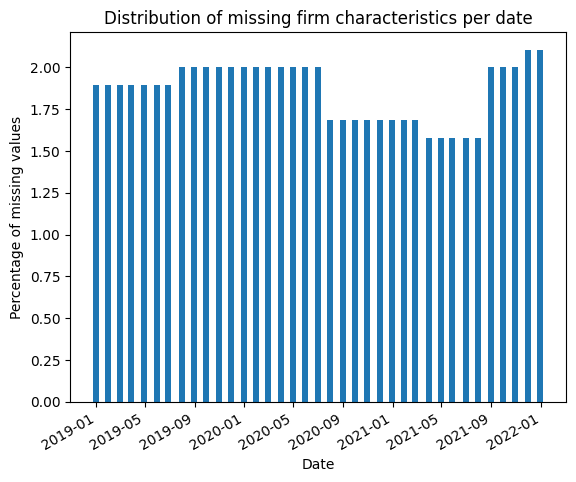

In [15]:
dataseries = df.sort("DATE").sort("permno")

dataseries = dataseries.filter(pl.col("DATE").is_between(period[0], period[1]))

dataseries_pd = dataseries.to_pandas()

missing_values = []

for date in dataseries_pd['DATE'].unique():
    missing_count = dataseries_pd[dataseries_pd['DATE'] == date].isnull().sum().sum()
    missing_values.append({'Date': date, 'Missing Values': missing_count})

missing_values_df = pd.DataFrame(missing_values)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

#Percentage of missing values
missing_values_percentage = (missing_values_df["Missing Values"]/(95*number_of_sso)*100)

# Plot a histogram of 'days_till_exp'
ax.bar(missing_values_df['Date'], missing_values_percentage, width=15)  

# # Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Distribution of missing firm characteristics per date')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

# # Show the plot
plt.show()

In [16]:
dataseries

permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,mom36m,pricedelay,turn,absacc,acc,age,agr,bm,bm_ia,cashdebt,cashpr,cfp,cfp_ia,chatoia,chcsho,chempia,chinv,chpmia,convind,currat,depr,divi,divo,dy,egr,…,quick,rd,rd_mve,rd_sale,realestate,roic,salecash,saleinv,salerec,secured,securedind,sgr,sin,sp,tang,tb,aeavol,cash,chtx,cinvest,ear,nincr,roaq,roavol,roeq,rsup,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
i64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10107,2018-12-31,8.5122e8,0.792636,0.628272,-0.053782,18.839129,0.019609,0.083138,0.042505,0.084676,0.284866,0.625372,0.088368,0.923185,0.084194,-0.084194,32.0,-0.244675,0.110646,-0.696143,0.19976,2.772572,0.074357,0.037661,-0.053429,-0.012807,0.001732,-0.000322,-1.114012,0.0,2.477273,0.328642,0.0,0.0,0.022661,0.005514,…,2.443473,0.0,0.024537,0.144936,0.445558,0.180436,0.676412,41.242549,4.544766,0.030584,1.0,0.054266,0.0,0.169298,0.667907,-0.757344,0.105917,0.538785,-0.001738,-0.082088,0.028976,1.0,0.029,0.017528,0.094742,0.005139,0.148041,0.217246,6.0,0.024451,3.8784e-12,0.039361,0.020227,0.297463,1.292838,2.2213e-8,73.0
10107,2019-01-31,7.8036e8,0.814186,0.662899,-0.124721,18.732203,0.020571,0.070997,-0.084047,0.133418,0.318027,0.618183,-0.012641,1.126247,0.109266,-0.109266,33.0,-0.073675,0.126325,-0.686314,0.153534,4.336732,0.057969,0.004641,0.047055,-0.004022,-0.03811,0.001924,0.740517,0.0,2.9008,0.273889,0.0,0.0,0.017063,0.142609,…,2.855287,0.0,0.019452,0.133436,0.489911,0.247114,0.82501,41.457551,4.167516,0.050345,1.0,0.226904,0.0,0.14578,0.670263,0.97968,0.504179,0.516782,0.007956,-0.100138,0.003229,2.0,0.036143,0.017803,0.111978,0.005918,0.143105,0.215009,6.0,0.038259,4.1434e-12,0.06831,0.027229,0.282718,2.374113,1.8718e-8,73.0
10107,2019-02-28,8.0121e8,0.832455,0.692982,-0.134055,18.717804,0.020039,-0.077373,0.028158,-0.034948,0.086919,0.810054,0.022188,1.033303,0.109266,-0.109266,33.0,-0.073675,0.126325,-0.696946,0.153534,4.336732,0.057969,0.004641,0.047055,-0.004022,-0.03811,0.001924,0.740517,0.0,2.9008,0.273889,0.0,0.0,0.017063,0.142609,…,2.855287,0.0,0.019452,0.133436,0.489911,0.247114,0.82501,41.457551,4.167516,0.050345,1.0,0.226904,0.0,0.14578,0.670263,0.97968,0.504179,0.516782,0.007956,-0.100138,0.003229,2.0,0.036143,0.017803,0.111978,0.005918,0.143105,0.215009,6.0,0.02037,4.1081e-12,0.046509,0.01979,0.207914,1.0357,2.2408e-8,73.0
10107,2019-03-29,8.5952e8,0.778968,0.606792,-0.201941,18.795006,0.020226,0.042863,0.077181,-0.066472,0.127253,0.929259,0.056188,0.924967,0.109266,-0.109266,33.0,-0.073675,0.126325,-0.705839,0.153534,4.336732,0.057969,0.004641,0.047055,-0.004022,-0.03811,0.001924,0.740517,0.0,2.9008,0.273889,0.0,0.0,0.017063,0.142609,…,2.855287,0.0,0.019452,0.133436,0.489911,0.247114,0.82501,41.457551,4.167516,0.050345,1.0,0.226904,0.0,0.14578,0.670263,0.97968,0.504179,0.516782,0.007956,-0.100138,0.003229,2.0,0.036143,0.017803,0.111978,0.005918,0.143105,0.215009,6.0,0.014431,3.1314e-12,0.028799,0.011382,0.193236,0.636321,3.7678e-8,73.0
10107,2019-04-30,9.0413e8,0.805571,0.648944,-0.223381,18.677404,0.019627,0.114413,0.052754,-0.012358,0.247516,0.729923,0.112662,0.770934,0.109266,-0.109266,33.0,-0.073675,0.126325,-0.706375,0.153534,4.336732,0.057969,0.004641,0.047055,-0.004022,-0.03811,0.001924,0.740517,0.0,2.9008,0.273889,0.0,0.0,0.017063,0.142609,…,2.855287,0.0,0.019452,0.133436,0.489911,0.247114,0.82501,41.457551,4.167516,0.050345,1.0,0.226904,0.0,0.14578,0.670263,0.97968,1.073058,0.527446,-0.000044,0.016637,-0.008981,0.0,0.03409,0.018032,0.106676,0.005176,0.144501,0.220843,6.0,0.015788,2.3830e-12,0.022975,0.010915,0.265477,1.045062,2.7120e-8,73.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…

[]

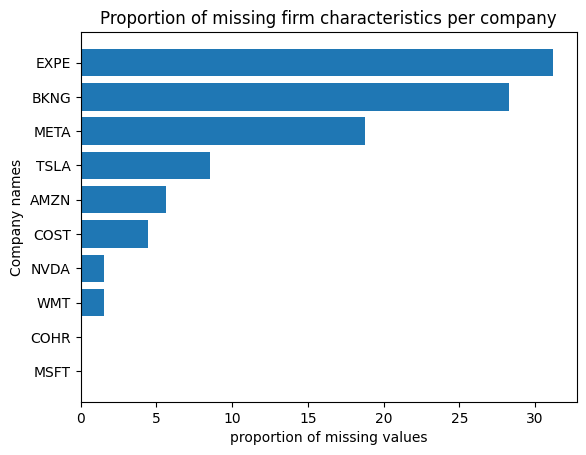

In [17]:
dataseries = df.sort("DATE").sort("permno")

dataseries = dataseries.filter(pl.col("DATE").is_between(period[0], period[1]))

dataseries_pd = dataseries.to_pandas()

total_missing = dataseries_pd.isnull().sum().sum()

missing_values = []

for permn in dataseries_pd['permno'].unique():
    missing_count = dataseries_pd[dataseries_pd['permno'] == permn].isnull().sum().sum()
    missing_values.append({'Permno': permn, 'Missing Values': missing_count})

missing_values_df = pd.DataFrame(missing_values).sort_values(by='Missing Values', ascending=True)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

#Percentage of missing values
missing_values_percentage = (missing_values_df["Missing Values"]/total_missing*100)
# missing_values_percentage = missing_values_percentage.sort_values()
# Create a dictionary mapping permno to ticker
permno_to_ticker = {permno: ticker for permno, ticker in zip(firm_permno, firm_tickers)}

# Convert the numbers to their corresponding names
firm_names = [permno_to_ticker.get(permno) for permno in missing_values_df['Permno']]

# Plot a histogram of 'days_till_exp'
ax.barh(firm_names, missing_values_percentage, height=0.8)  

# # Add labels and title
ax.set_xlabel('proportion of missing values')
ax.set_ylabel('Company names')
ax.set_title('Proportion of missing firm characteristics per company')

plt.plot()

# Columns containing missing values #

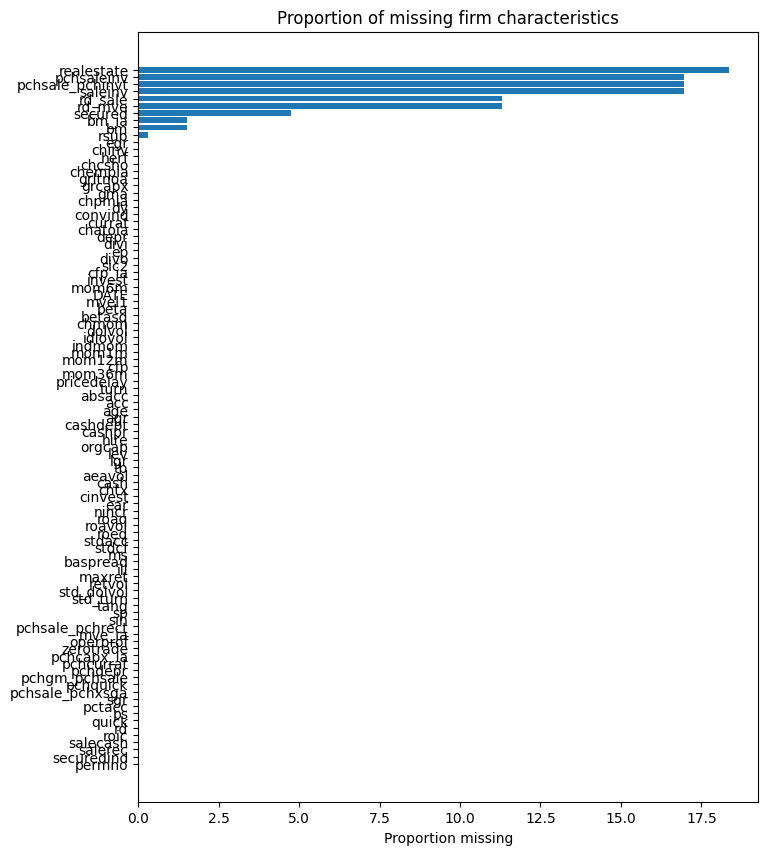

In [18]:
import matplotlib.pyplot as plt

# Total missing firm characteristics
total_missing = dataseries_pd.isnull().sum().sum()
# Get the column names
column_names = dataseries_pd.columns.tolist()

# pandas_df = dataseries_pd.to_pandas()
pandas_df = dataseries_pd.isna().sum()

pandas_df

# Transpose the DataFrame
transposed_df = pandas_df.T

# Sort the DataFrame by the first row
sorted_df = transposed_df.sort_values(ascending = True)

sorted_df
# Transpose the DataFrame back
sorted_df = sorted_df.T

# list_y = sorted_df.columns.tolist()
list_y = (sorted_df.values / total_missing * 100).tolist()
column_names = sorted_df.index.tolist()

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8,10))

# Plot a horizontal bar plot of unique counts
ax.barh(column_names, list_y)

# Add labels and title
ax.set_xlabel('Proportion missing')
# ax.set_ylabel('Variables')
ax.set_title('Proportion of missing firm characteristics')

# plt.rc('axes', labelsize=6)    # fontsize of the x and y labels
plt.rc('font', size=8)          # controls default text sizes

# Show the plot
plt.show()



# Insert the median in the missing data

In [19]:
complete_dataseries = dataseries_pd.copy()

for column in complete_dataseries.columns:
    median_value = complete_dataseries[column].median()
    complete_dataseries.loc[complete_dataseries[column].isnull(), column] = median_value

complete_dataseries

single_dataseries = complete_dataseries[complete_dataseries['permno'] == 10107].copy()

permnos = complete_dataseries['permno'].unique()

# permnos = [10107]

# Initialize an empty list to store the DataFrames
all_daily_dfs = []

# Iterate over the unique 'permno' values
for permno in permnos:
    # Select the rows with the current 'permno' value
    df = complete_dataseries[complete_dataseries['permno'] == permno].copy()
    
    # Convert 'DATE' to datetime and set it as the index
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)
    
    # Resample to daily data
    daily_df = df.resample('D').asfreq()

    # Fill missing 'permno' values with the current 'permno'
    daily_df['permno'] = daily_df['permno'].fillna(permno)
    
    # Interpolate missing values
    for column in daily_df.columns:
        if column != 'permno': # Exclude 'permno'
                daily_df[column] = daily_df[column].interpolate(method='spline', order=2)
    
    # Append the DataFrame to 'all_daily_dfs'
    all_daily_dfs.append(daily_df)

# Concatenate all the DataFrames in 'all_daily_dfs'
all_daily_dfs = pd.concat(all_daily_dfs)

# Reset the index of 'all_daily_dfs'
all_daily_dfs.reset_index(inplace=True)

all_daily_dfs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


,DATE,permno,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
0,2018-12-31,10107.0,8.512159e+08,0.792636,0.628272,-0.053782,18.839129,0.019609,0.083138,0.042505,...,0.217246,6.000000,0.024451,3.878408e-12,0.039361,0.020227,0.297463,1.292838,2.221272e-08,73.0
1,2019-01-01,10107.0,8.472853e+08,0.853462,0.724754,-0.020403,18.613223,0.019183,0.024877,0.026541,...,0.220573,6.000000,0.017393,3.572595e-12,0.031329,0.013228,0.254590,1.041284,3.023292e-08,73.0
2,2019-01-02,10107.0,8.434644e+08,0.853397,0.724643,-0.020350,18.613804,0.019184,0.024549,0.026555,...,0.220544,6.000000,0.017417,3.570363e-12,0.031362,0.013254,0.254647,1.042189,3.021364e-08,73.0
3,2019-01-03,10107.0,8.397531e+08,0.853331,0.724532,-0.020296,18.614384,0.019185,0.024223,0.026568,...,0.220514,6.000000,0.017440,3.568130e-12,0.031395,0.013281,0.254704,1.043093,3.019439e-08,73.0
4,2019-01-04,10107.0,8.361515e+08,0.853265,0.724420,-0.020242,18.614965,0.019186,0.023899,0.026582,...,0.220485,6.000000,0.017464,3.565898e-12,0.031428,0.013307,0.254761,1.043994,3.017519e-08,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10965,2021-12-27,93436.0,1.168461e+09,1.595474,2.451778,-1.361501,19.180857,0.087370,0.974188,0.026670,...,0.175464,6.284319,0.034902,4.104699e-13,0.055635,0.022848,0.293461,12.803693,4.907737e-09,37.0
10966,2021-12-28,93436.0,1.164390e+09,1.596395,2.454040,-1.367251,19.181317,0.087387,0.976103,0.026028,...,0.175444,6.290579,0.034827,4.087144e-13,0.055440,0.022760,0.293124,12.561984,4.918070e-09,37.0
10967,2021-12-29,93436.0,1.159897e+09,1.597317,2.456304,-1.373010,19.181776,0.087404,0.978019,0.025385,...,0.175424,6.296847,0.034752,4.069743e-13,0.055244,0.022671,0.292785,12.305879,4.928417e-09,37.0
10968,2021-12-30,93436.0,1.154981e+09,1.598239,2.458569,-1.378777,19.182236,0.087421,0.979937,0.024740,...,0.175404,6.303124,0.034676,4.052495e-13,0.055048,0.022583,0.292447,12.035377,4.938781e-09,37.0


# Save the 2-dimensional Spline

In [20]:
# Saving file
data_spline_path_parq = Path.cwd().parent / "Data/Firm_variables/daily_firm_data_spline.parquet"

save_parquet = False
if save_parquet or not os.path.exists(data_spline_path_parq):
    all_daily_dfs.to_parquet(data_spline_path_parq)

# Plot of the data


In [30]:
group_sizes = all_daily_dfs.groupby(['permno']).size()
print(group_sizes)

permno
10107.0    1097
13407.0    1097
24476.0    1097
55976.0    1097
84788.0    1097
86580.0    1097
86783.0    1097
87055.0    1097
90808.0    1097
93436.0    1097
dtype: int64


In [46]:
def standardize(series):
    # Map the ranks of the series into the [-1, 1] interval
    return 2.0 * (series.rank() / series.count() - 0.5)

# Select all columns except 'DATE' and 'permno'
columns_to_standardize = all_daily_dfs.columns.difference(['DATE', 'permno'])

# Group all_daily_dfs by 'permno' and 'DATE' and apply the standardize function to each group
pd_merged_standardized = all_daily_dfs.groupby(['permno'])[columns_to_standardize].apply(standardize)

# Reset the index to keep the 'permno' and 'DATE' columns
pd_merged_standardized.reset_index(inplace=True)

# Set 'DATE' and 'permno' as the index
pd_merged_standardized.set_index(['permno', all_daily_dfs['DATE']], inplace=True)

# Drop the 'level_1' column
pd_merged_standardized.drop('level_1', axis=1, inplace=True)

pd_merged_standardized

absacc       acc    aeavol       age       agr  \
permno  DATE                                                           
10107.0 2018-12-31  0.484047 -0.482224 -0.981768 -0.998177 -0.998177   
        2019-01-01  1.000000 -0.998177  0.983592 -0.996354 -0.602552   
        2019-01-02  0.998177 -0.996354  0.981768 -0.994531 -0.606199   
        2019-01-03  0.996354 -0.994531  0.979945 -0.992707 -0.609845   
        2019-01-04  0.994531 -0.992707  0.978122 -0.990884 -0.613491   
...                      ...       ...       ...       ...       ...   
93436.0 2021-12-27  0.983592 -0.981768 -0.992707  0.994531 -0.992707   
        2021-12-28  0.985415 -0.983592 -0.994531  0.996354 -0.994531   
        2021-12-29  0.987238 -0.985415 -0.996354  0.998177 -0.996354   
        2021-12-30  0.989061 -0.987238 -0.998177  1.000000 -0.998177   
        2021-12-31  0.995442 -0.993619 -0.642662  0.964448 -0.922516   

                    baspread      beta    betasq        bm     bm_ia  ...  \
permno  DATE                                                          ...   
10107.0 2018-12-31  0.987238  0.329079  0.294439  0.090246 -0.099362  ...   
        2019-01-01 -0.702826  0.989061  0.989061  0.850501 -0.019143  ...   
        2019-01-02 -0.699180  0.987238  0.987238  0.854148 -0.015497  ...   
        2019-01-03 -0.695533  0.985415  0.985415  0.857794 -0.011851  ...   
        2019-01-04 -0.691887  0.983592  0.983592  0.861440 -0.008204  ...   
...                      ...       ...       ...       ...       ...  ...   
93436.0 2021-12-27 -0.797630  0.994531  0.994531 -0.981768  0.989061  ...   
        2021-12-28 -0.801276  0.996354  0.996354 -0.983592  0.990884  ...   
        2021-12-29 -0.804923  0.998177  0.998177 -0.985415  0.992707  ...   
        2021-12-30 -0.808569  1.000000  1.000000 -0.987238  0.994531  ...   
        2021-12-31  0.987238  0.810392  0.839562 -0.993619  0.997265  ...   

                         sin        sp  std_dolvol  std_turn    stdacc  \
permno  DATE                                                             
10107.0 2018-12-31  0.000912  1.000000    0.987238  0.983592  1.000000   
        2019-01-01  0.000912  0.998177   -0.673655 -0.597083  0.992707   
        2019-01-02  0.000912  0.996354   -0.670009 -0.593437  0.990884   
        2019-01-03  0.000912  0.994531   -0.666363 -0.589790  0.989061   
        2019-01-04  0.000912  0.992707   -0.662716 -0.586144  0.987238   
...                      ...       ...         ...       ...       ...   
93436.0 2021-12-27  0.000912 -0.992707   -0.970830 -0.398359 -0.992707   
        2021-12-28  0.000912 -0.994531   -0.972653 -0.420237 -0.994531   
        2021-12-29  0.000912 -0.996354   -0.974476 -0.440292 -0.996354   
        2021-12-30  0.000912 -0.998177   -0.976299 -0.458523 -0.998177   
        2021-12-31  0.000912 -0.938924    0.237922 -0.485871 -0.826800   

                       stdcf      tang        tb      turn  zerotrade  
permno  DATE                                                           
10107.0 2018-12-31  0.777575  0.739289 -0.340018  0.981768  -0.983592  
        2019-01-01  0.994531  1.000000  0.978122 -0.704649   0.863263  
        2019-01-02  0.992707  0.998177  0.976299 -0.701003   0.859617  
        2019-01-03  0.990884  0.996354  0.974476 -0.697356   0.855971  
        2019-01-04  0.989061  0.994531  0.972653 -0.693710   0.852325  
...                      ...       ...       ...       ...        ...  
93436.0 2021-12-27  0.057429  0.994531 -0.970830 -0.861440   0.990884  
        2021-12-28  0.053783  0.996354 -0.972653 -0.855971   0.992707  
        2021-12-29  0.050137  0.998177 -0.974476 -0.852325   0.994531  
        2021-12-30  0.046490  1.000000 -0.976299 -0.848678   0.996354  
        2021-12-31  0.998177  0.971741 -0.371923 -0.733820   0.649954  

[10970 rows x 95 columns]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


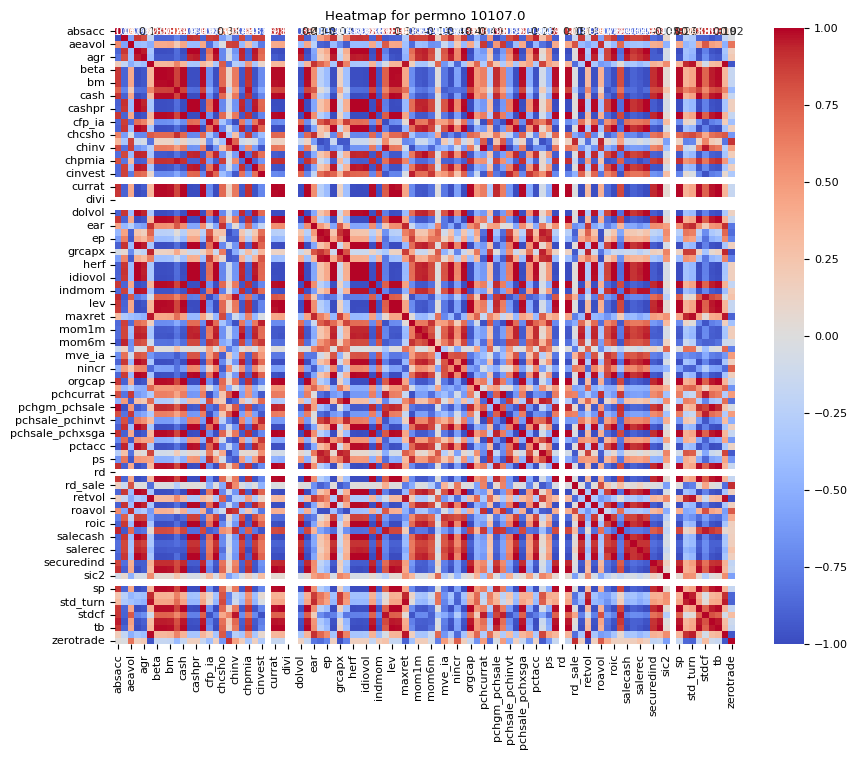

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


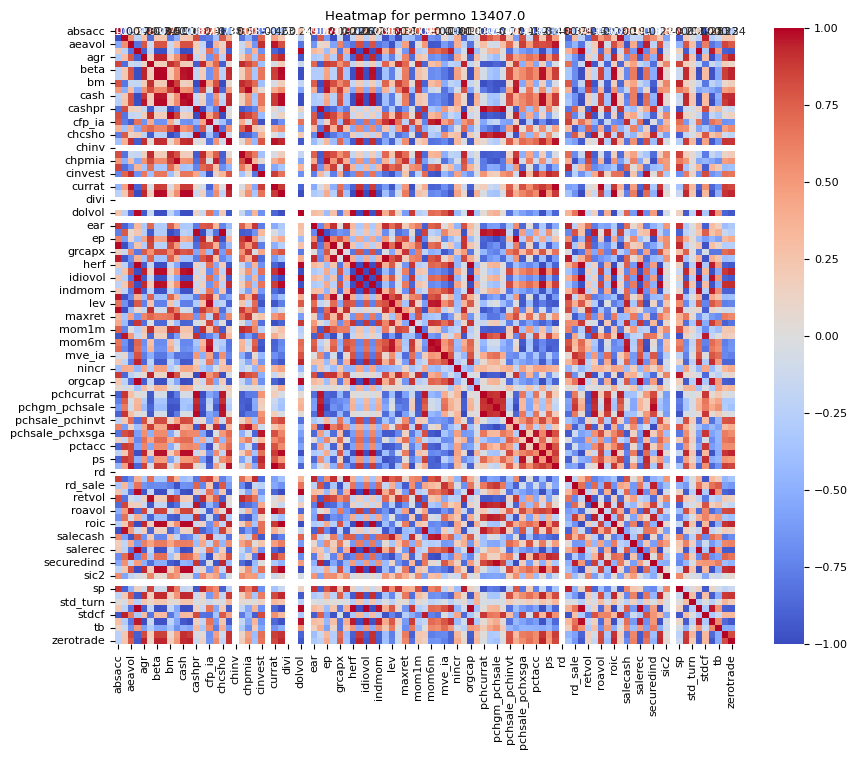

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


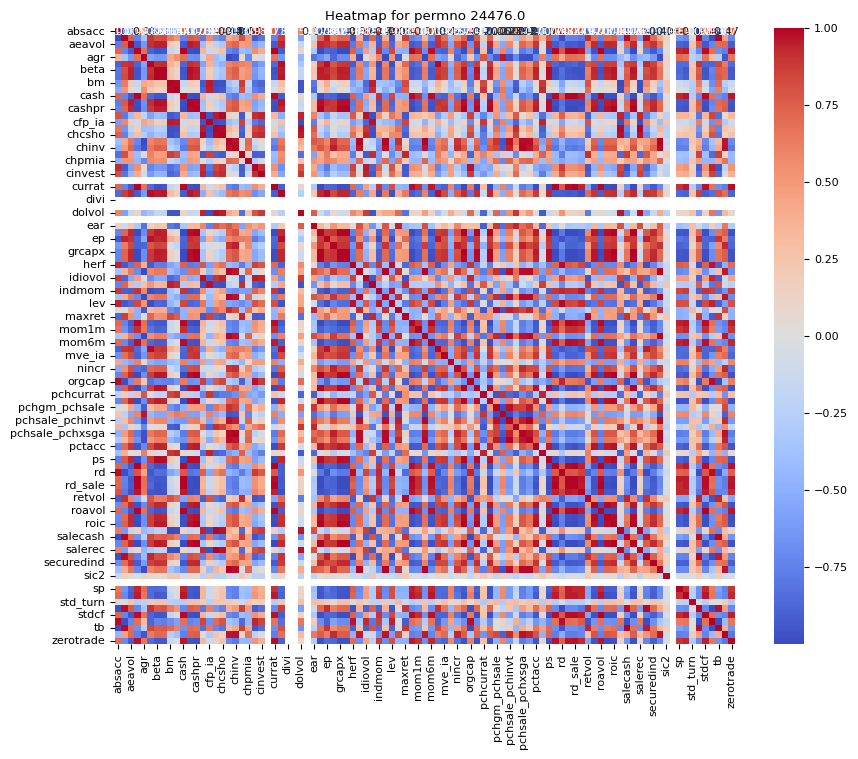

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


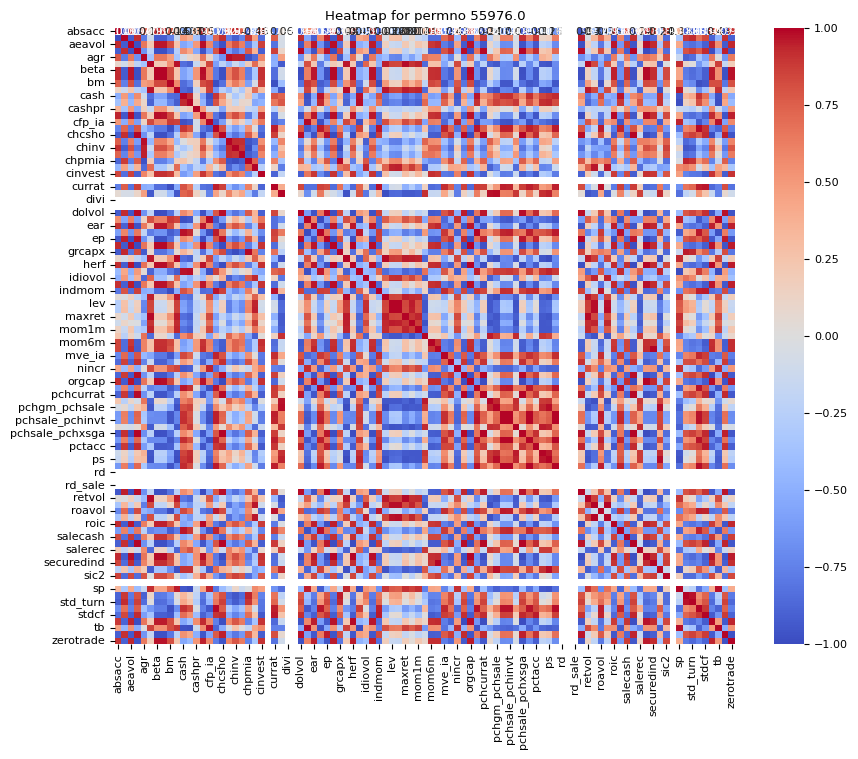

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


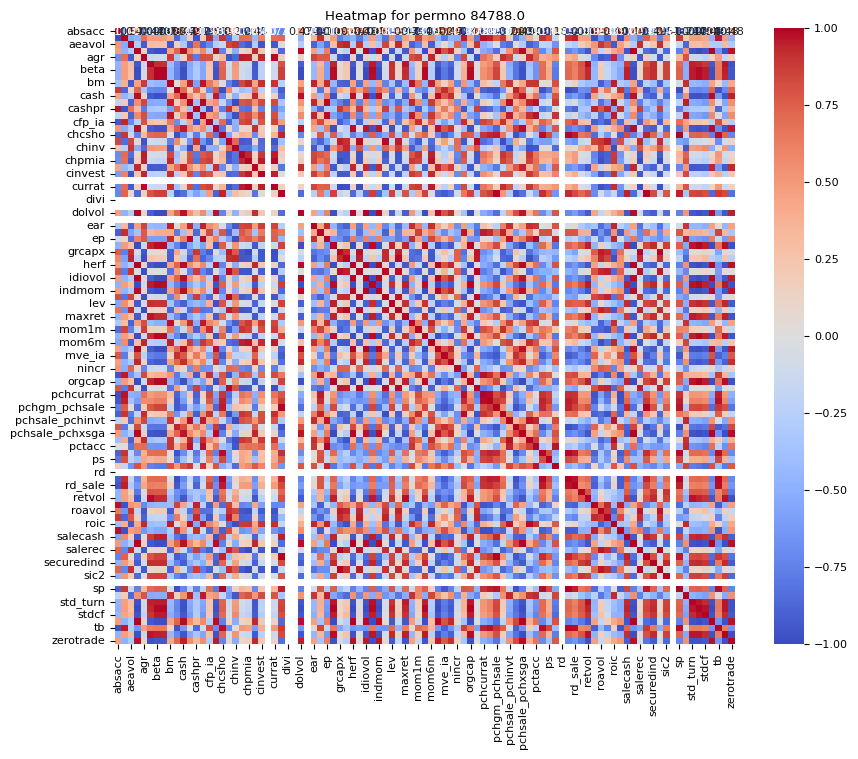

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


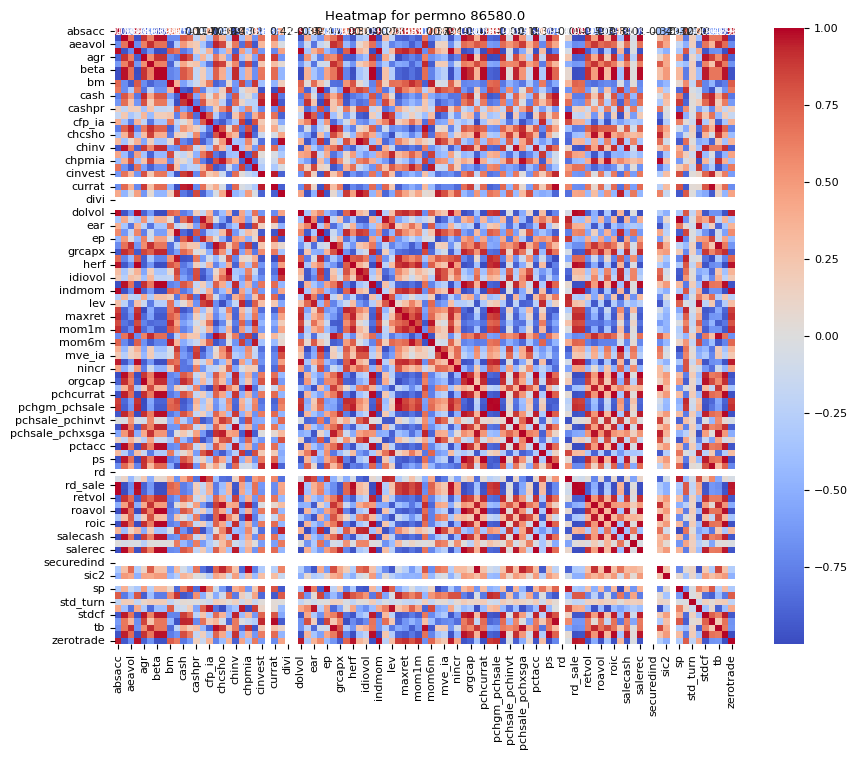

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


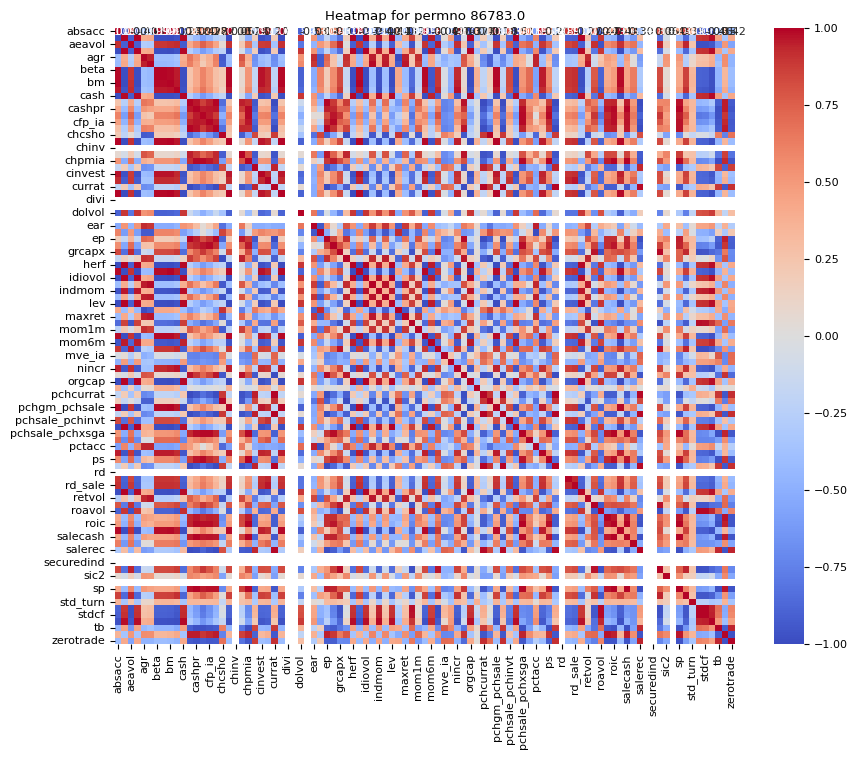

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


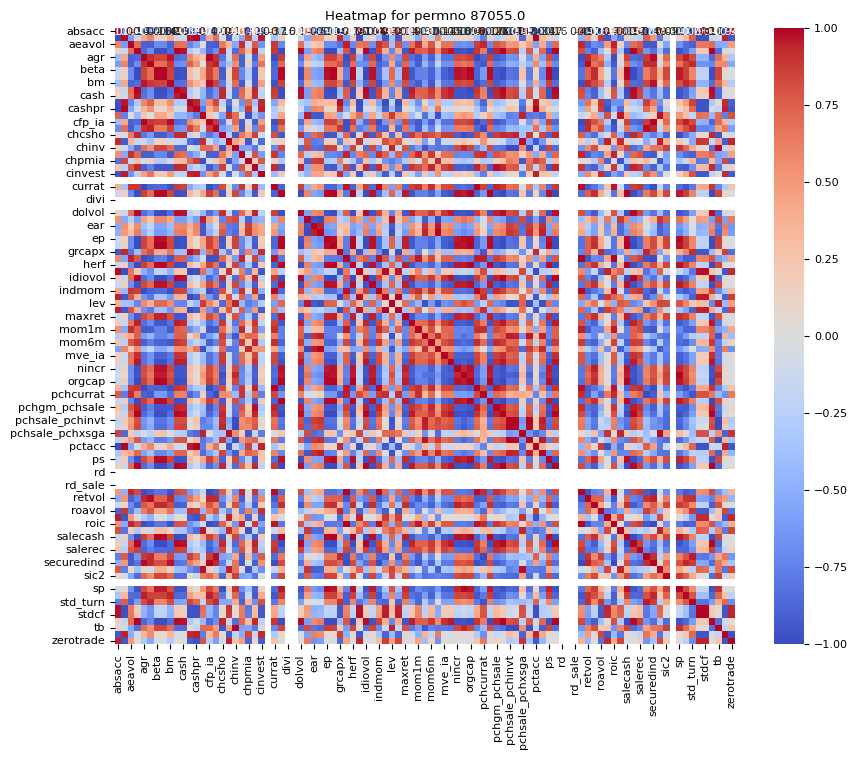

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


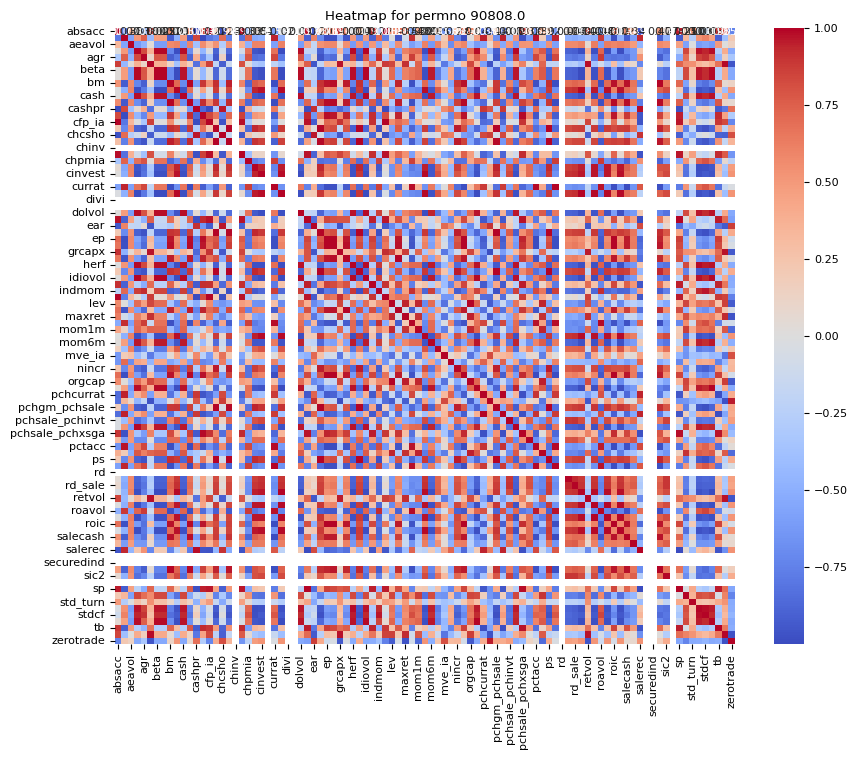

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


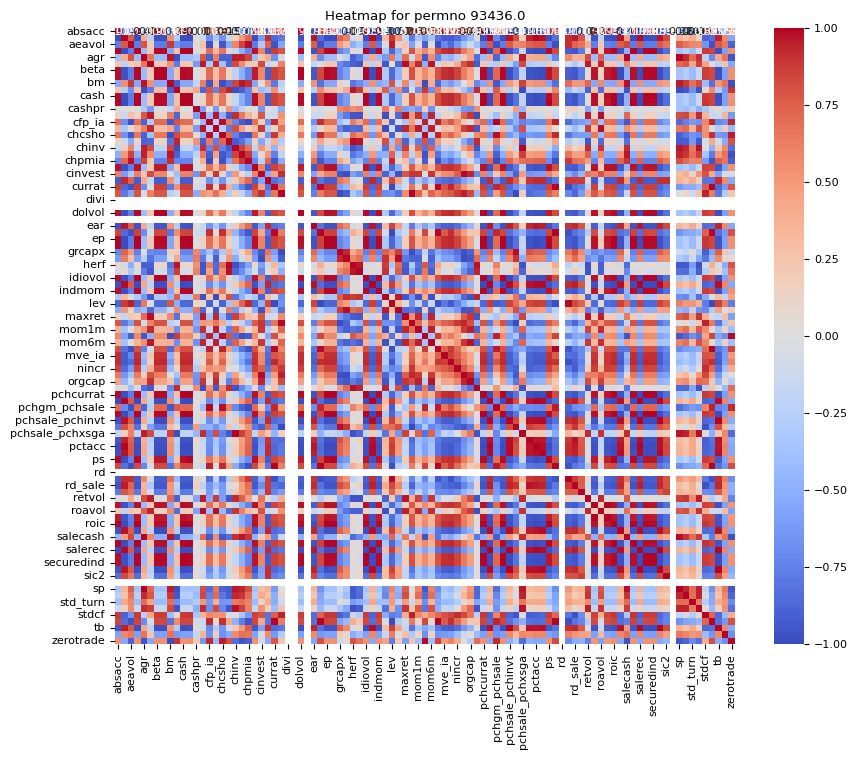

In [49]:
# Get the unique 'permno' values
permnos = pd_merged_standardized.index.get_level_values('permno').unique()

# For each 'permno', create a heatmap of the features
for permno in permnos:
    plt.figure(figsize=(10, 8))
    sns.heatmap(pd_merged_standardized.loc[permno].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Heatmap for permno {permno}')
    plt.show()

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43548/2071759317.py:4: DeprecationWarning: `approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.
  df.approx_n_unique()
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_43548/2071759317.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


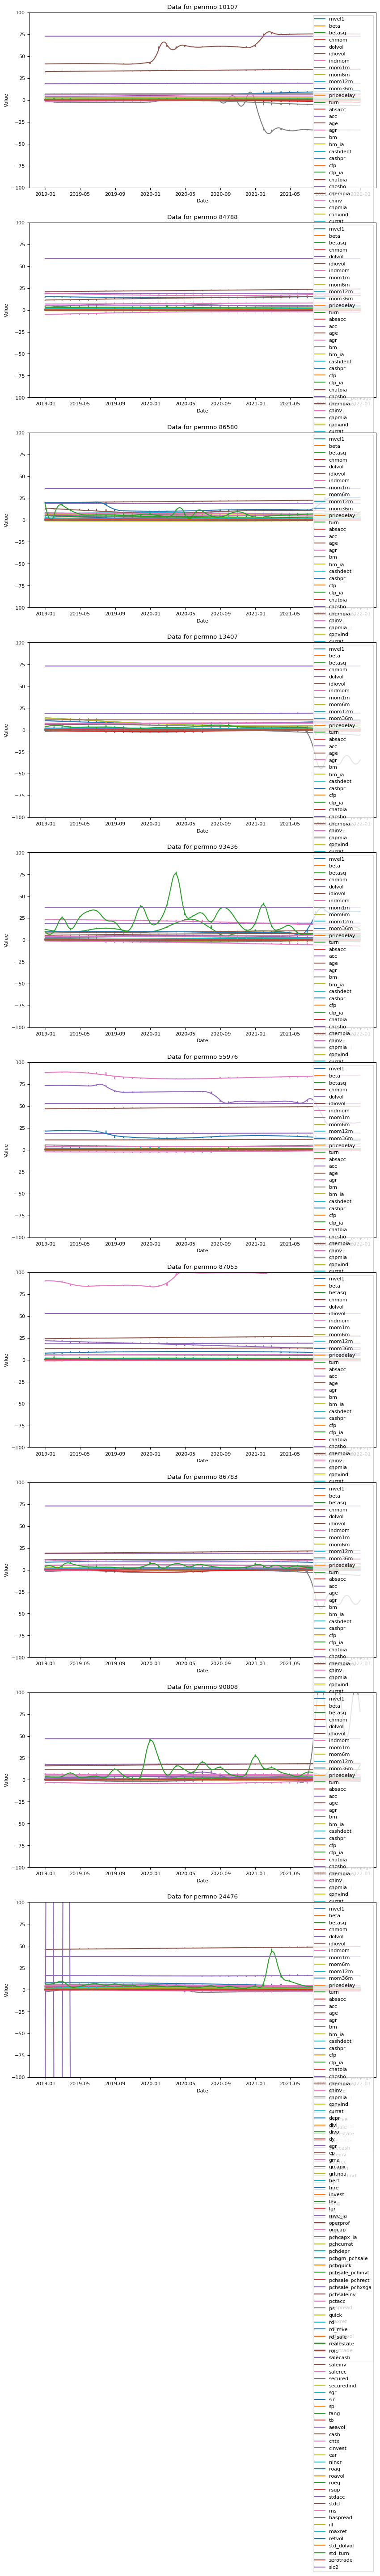

In [23]:
firm_permno = [10107, 84788, 86580, 13407, 93436, 55976, 87055, 86783, 90808, 24476]

df = pl.from_pandas(all_daily_dfs)
df.approx_n_unique()


import matplotlib.pyplot as plt

# Get unique 'permno' values
permnos = firm_permno  # Use 'firm_permno' instead of 'permnos'

# Create a new figure with 10 subplots
fig, axs = plt.subplots(len(permnos), 1, figsize=(10, 60))  # Adjust the size as needed

# Iterate over the unique 'permno' values
for i, permno in enumerate(permnos):
    # Select the rows with the current 'permno' value
    df = all_daily_dfs[all_daily_dfs['permno'] == permno]
    
    # Plot each column
    for column in df.columns:
        if column not in ['DATE', 'permno']:  # Exclude 'DATE' and 'permno'
            axs[i].plot(df['DATE'], df[column], label=column)

    # Set the title and labels
    axs[i].set_title(f'Data for permno {permno}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Value')

    # Limit the y-axis to values between -100 and 100
    axs[i].set_ylim(-100, 100)

    # Add a legend
    axs[i].legend()

# Show the plot
plt.tight_layout()
plt.show()